<a href="https://colab.research.google.com/github/LeeYoungWook/dd/blob/master/GAN%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gan**

![대체 텍스트](https://raw.githubusercontent.com/LeeYoungWook/dd/master/sadsadsaa.PNG)




In [0]:

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [0]:

# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [0]:

# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


In [0]:

# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

In [0]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

In [0]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [0]:
#결과값: 1시간 30분 걸림

total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], d_loss: 0.0944, g_loss: 3.8645, D(x): 0.97, D(G(z)): 0.05
Epoch [1/500], d_loss: 0.0503, g_loss: 5.7646, D(x): 0.99, D(G(z)): 0.02
Epoch [2/500], d_loss: 0.0158, g_loss: 6.0480, D(x): 1.00, D(G(z)): 0.01
Epoch [3/500], d_loss: 0.0356, g_loss: 5.5535, D(x): 1.00, D(G(z)): 0.03
Epoch [4/500], d_loss: 0.0207, g_loss: 6.9220, D(x): 0.99, D(G(z)): 0.01
Epoch [5/500], d_loss: 0.0802, g_loss: 6.8762, D(x): 0.98, D(G(z)): 0.02
Epoch [6/500], d_loss: 0.1711, g_loss: 6.0730, D(x): 0.96, D(G(z)): 0.06
Epoch [7/500], d_loss: 0.1716, g_loss: 4.7396, D(x): 0.97, D(G(z)): 0.09
Epoch [8/500], d_loss: 0.1305, g_loss: 3.9854, D(x): 0.97, D(G(z)): 0.07
Epoch [9/500], d_loss: 0.2602, g_loss: 5.1508, D(x): 0.93, D(G(z)): 0.04
Epoch [10/500], d_loss: 0.3055, g_loss: 4.3838, D(x): 0.88, D(G(z)): 0.03
Epoch [11/500], d_loss: 0.1315, g_loss: 4.7074, D(x): 0.98, D(G(z)): 0.09
Epoch [12/500], d_loss: 0.2522, g_loss: 5.9269, D(x): 0.91, D(G(z)): 0.04
Epoch [13/500], d_loss: 0.3634, g_loss: 3.5211, 

# **기존 GAN의 한계와 이를 해결하기 위한 다양한 GAN의 등장**

1. GAN은 결과가 불안정하다
기존 GAN만 가지고는 좋은 성능이 잘 안나왔다.

2. Black-box method
Neural Network 자체의 한계라고 볼 수 있는데, 결정 변수나 주요 변수를 알 수 있는 다수의 머신러닝 기법들과 달리 Neural Network은 처음부터 끝까지 어떤 형태로 그러한 결과가 나오게 되었는지 그 과정을 알 수 없다.

3. Generative Model 평가
GAN은 결과물 자체가 새롭게 만들어진 Sample 이다. 이를 기존 sample과 비교하여 얼마나 비슷한 지 확인할 수 있는 정량적 척도가 없고, 사람이 판단하더라도 이는 주관적 기준이기 때문에 얼마나 정확한지, 혹은 뛰어난지 판단하기 힘들다.


**Generator와 disciminator에 특정 conditon을 나타내는 정보y를 추가해주면 Original GAN을 다양한 형태로 활용이 가능하다**

# **cGAN**

*   기존의 GAN의 생성자가 랜덤 벡터를 입력으로 받는 것에 비해 cGAN의 생성자는 변형할 이미지를 입력으로 받는다. 그 뒤 생성자는 입력 이미지에 맞는 변형된 이미지를 출력한다.

*  주어진 이미지를 새로운 이미지로 변형하는 수많은 문제를 하나의 간단한 네트워크 구조로 모두 풀수 있다.





In [0]:

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [0]:

# 하이퍼파라미터
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [0]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


In [0]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [0]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [0]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)

In [0]:
#결과값 1시간 10분걸림

total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

이폭 [0/300] d_loss:0.6217 g_loss: 3.3864 D(x):0.80 D(G(z)):0.19
이폭 [1/300] d_loss:0.5563 g_loss: 2.6957 D(x):0.88 D(G(z)):0.26
이폭 [2/300] d_loss:0.4011 g_loss: 4.8174 D(x):0.86 D(G(z)):0.09
이폭 [3/300] d_loss:0.2804 g_loss: 3.3607 D(x):0.92 D(G(z)):0.10
이폭 [4/300] d_loss:0.7409 g_loss: 2.5439 D(x):0.69 D(G(z)):0.14
이폭 [5/300] d_loss:0.4109 g_loss: 2.2012 D(x):0.89 D(G(z)):0.20
이폭 [6/300] d_loss:0.9397 g_loss: 1.7427 D(x):0.69 D(G(z)):0.22
이폭 [7/300] d_loss:0.6596 g_loss: 2.2369 D(x):0.79 D(G(z)):0.24
이폭 [8/300] d_loss:0.6752 g_loss: 2.1470 D(x):0.75 D(G(z)):0.20
이폭 [9/300] d_loss:1.1295 g_loss: 1.1926 D(x):0.64 D(G(z)):0.37
이폭 [10/300] d_loss:1.1187 g_loss: 1.5153 D(x):0.57 D(G(z)):0.25
이폭 [11/300] d_loss:0.8569 g_loss: 1.4439 D(x):0.80 D(G(z)):0.34
이폭 [12/300] d_loss:0.6511 g_loss: 1.4561 D(x):0.79 D(G(z)):0.26
이폭 [13/300] d_loss:0.9820 g_loss: 1.5432 D(x):0.71 D(G(z)):0.32
이폭 [14/300] d_loss:0.8579 g_loss: 1.4780 D(x):0.68 D(G(z)):0.29
이폭 [15/300] d_loss:0.6207 g_loss: 1.9113 D(x):0.73

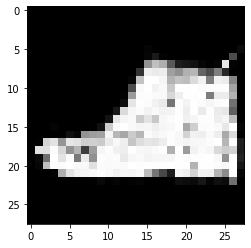

In [0]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()

# **DCGAN**

*  GAN과 DCGAN의 전체적인 구조는 거의 유사하다. 다만 각각의 Discriminator와 Generator의 세부적인 구조가 달라진다.

![대체 텍스트](https://github.com/LeeYoungWook/dd/blob/master/gan.PNG?raw=true)

*   DCGAN은 결국, 기존 GAN에 존재했던 fully-connected구조의 대부분을 CNN 구조로 대체한 것이다.

*   구분자에서는 모든 pooling layers를 strided convolutions 로 바꾸고, G생성자에서는 pooling layers를 fractional-strided convolutions 으로 바꾼다.

*   DCGAN은 마지막 레이어를 제외하고 생성자의 모든 레이어에 ReLU를 사용했고, 구분자의 모든 레이어에 LeakyReLU를 사용했다

*   DCGAN의 생성자는 GAN과 마찬가지로 랜덤 벡터 z를 받고 가짜 이미지를 생성하는 함수다. 기존의 convolutions는 필터를 거치며 크기가 작아진 반면에, fractionally-strided convolutions은 input에 padding을 하고 convolution을 하면서 오히려 크기가 더 커지는 특징이 있다. 쉽게 transposed convolution이라한다.






In [0]:
### 라이브러리 및 데이터 불러오기
# 필요한 라이브러리를 불러온다.
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pickle

# 데이터 전처리 방식을 지정한다.
transform = transforms.Compose([
        transforms.ToTensor(), # 데이터를 PyTorch의 Tensor 형식으로 바꾼다.
        transforms.Normalize(mean=(0.5,), std=(0.5,)) # 픽셀값 0 ~ 1 -> -1 ~ 1
])

# MNIST 데이터셋을 불러온다. 지정한 폴더에 없을 경우 자동으로 다운로드한다.
mnist = datasets.MNIST(root='data', download=True, transform=transform)

# 데이터를 한번에 batch_size만큼만 가져오는 dataloader를 만든다.
dataloader = DataLoader(mnist, batch_size=60, shuffle=True)

In [0]:
import os
import imageio

if torch.cuda.is_available():
    use_gpu = True
leave_log = True
if leave_log:
    result_dir = 'DCGAN_generated_images'
    if not os.path.isdir(result_dir):
        os.mkdir(result_dir)


*   생성자는 랜덤 벡터 ‘z’를 입력으로 받아 가짜 이미지를 출력하는 함수다. 여기서 ‘z’는 단순하게 균등 분포(Uniform Distribution)나 정규 분포(Normal Distribution)에서 무작위로 추출된 값이다.

*   z’ 벡터가 존재하는 공간을 잠재 공간(Latent Space)이라고도 부른다. 여기서는 잠재 공간의 크기를 임의로 100차원으로 뒀다. 

*   이 모델에서는 100차원의 랜덤 벡터를 받아 이를 256개의 뉴런을 가진 레이어로 보내고, 다시 레이어의 크기를 512, 1024로 점점 증가시켰다. 마지막에는 출력을 MNIST 이미지의 크기로 맞추기 위해 레이어 크기를 28x28로 줄였다.










*   생성자의 LeakyReLU는 각 뉴런의 출력값이 0보다 높으면 그대로 놔두고, 0보다 낮으면 정해진 작은 숫자를 곱하는 간단한 함수다. 여기서는 0.2를 곱했다.
*   생성자의 마지막 레이어에서는 출력값을 픽셀값의 범위인 -1과 1 사이로 만들어주기 위해 Tanh를 사용했다.







*   구분자의 LeakyReLU는 입력값으로 이미지 크기인 28x28개의 변수를 받은 뒤 레이어의 크기가 28x28에서 1024로, 512로, 256으로 점차 줄어들다. 마지막에는 확률값을 나타내는 숫자 하나를 출력한다.

*   구분자의 마지막 레이어에서는 출력값을 0과 1 사이로 만들기 위해 활성 함수로 Sigmoid를 넣었다.







In [0]:
### DCGAN의 생성자
class Generator(nn.Module):
    
    # 네트워크 구조
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=28*8, 
                               kernel_size=7, stride=1, padding=0, 
                               bias=False),
            nn.BatchNorm2d(num_features=28*8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=28*8, out_channels=28*4, 
                               kernel_size=4, stride=2, padding=1, 
                               bias=False),
            nn.BatchNorm2d(num_features=28*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=28*4, out_channels=1, 
                               kernel_size=4, stride=2, padding=1, 
                               bias=False),
            nn.Tanh())
        
    # (batch_size x 100) 크기의 랜덤 벡터를 받아 
    # 이미지를 (batch_size x 1 x 28 x 28) 크기로 출력한다.
    def forward(self, inputs):
        inputs = inputs.view(-1, 100, 1, 1)
        return self.main(inputs)

In [0]:
### DCGAN의 구분자
class Discriminator(nn.Module):
    
    # 네트워크 구조
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=28*4, 
                      kernel_size=4, stride=2, padding=1, 
                      bias=False),
            nn.BatchNorm2d(num_features=28*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=28*4, out_channels=28*8, 
                      kernel_size=4, stride=2, padding=1, 
                      bias=False),
            nn.BatchNorm2d(num_features=28*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=28*8, out_channels=1, 
                      kernel_size=7, stride=1, padding=0, 
                      bias=False),
            nn.Sigmoid())
        
    # (batch_size x 1 x 28 x 28) 크기의 이미지를 받아
    # 이미지가 진짜일 확률을 0~1 사이로 출력한다.
    def forward(self, inputs):
        o = self.main(inputs)
        return o.view(-1, 1)

In [0]:
### 생성자와 구분자 객체 만들기
G = Generator()
D = Discriminator()

if use_gpu:
    G.cuda()
    D.cuda()

In [0]:
### 손실 함수와 최적화 기법 지정하기
# Binary Cross Entropy loss
criterion = nn.BCELoss()

# 생성자의 매개 변수를 최적화하는 Adam optimizer
G_optimizer = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# 구분자의 매개 변수를 최적화하는 Adam optimizer
D_optimizer = Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
# 학습 결과 시각화하기
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def square_plot(data, path):
    """Take an array of shape (n, height, width) or (n, height, width , 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""

    if type(data) == list:
	    data = np.concatenate(data)
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))

    padding = (((0, n ** 2 - data.shape[0]) ,
                (0, 1), (0, 1))  # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data , padding, mode='constant' , constant_values=1)  # pad with ones (white)

    # tilethe filters into an image
    data = data.reshape((n , n) + data.shape[1:]).transpose((0 , 2 , 1 , 3) + tuple(range(4 , data.ndim + 1)))

    data = data.reshape((n * data.shape[1] , n * data.shape[3]) + data.shape[4:])

    plt.imsave(path, data, cmap='gray')

In [0]:
if leave_log:
    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
    generated_images = []
    
z_fixed = Variable(torch.randn(5 * 5, 100), volatile=True)
if use_gpu:
    z_fixed = z_fixed.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


In [0]:
### 모델 학습을 위한 반복문
# 데이터셋을 100번 돌며 학습한다.
for epoch in range(100):
    
    if leave_log:
        D_losses = []
        G_losses = []
    
    # 한번에 batch_size만큼 데이터를 가져온다.
    for real_data, _ in dataloader:
        batch_size = real_data.size(0)
        
        # 데이터를 pytorch의 변수로 변환한다.
        real_data = Variable(real_data)

        ### 구분자 학습시키기

        # 이미지가 진짜일 때 정답 값은 1이고 가짜일 때는 0이다.
        # 정답지에 해당하는 변수를 만든다.
        target_real = Variable(torch.ones(batch_size, 1))
        target_fake = Variable(torch.zeros(batch_size, 1))
         
        if use_gpu:
            real_data, target_real, target_fake = real_data.cuda(), target_real.cuda(), target_fake.cuda()
            
        # 진짜 이미지를 구분자에 넣는다.
        D_result_from_real = D(real_data)
        # 구분자의 출력값이 정답지인 1에서 멀수록 loss가 높아진다.
        D_loss_real = criterion(D_result_from_real, target_real)

        # 생성자에 입력으로 줄 랜덤 벡터 z를 만든다.
        z = Variable(torch.randn((batch_size, 100)))
        
        if use_gpu:
            z = z.cuda()
            
        # 생성자로 가짜 이미지를 생성한다.
        fake_data = G(z)
        
        # 생성자가 만든 가짜 이미지를 구분자에 넣는다.
        D_result_from_fake = D(fake_data)
        # 구분자의 출력값이 정답지인 0에서 멀수록 loss가 높아진다.
        D_loss_fake = criterion(D_result_from_fake, target_fake)
        
        # 구분자의 loss는 두 문제에서 계산된 loss의 합이다.
        D_loss = D_loss_real + D_loss_fake
        
        # 구분자의 매개 변수의 미분값을 0으로 초기화한다.
        D.zero_grad()
        # 역전파를 통해 매개 변수의 loss에 대한 미분값을 계산한다.
        D_loss.backward()
        # 최적화 기법을 이용해 구분자의 매개 변수를 업데이트한다.
        D_optimizer.step()
        
        if leave_log:
            D_losses.append(D_loss.data[0])

        # train generator G

        ### 생성자 학습시키기
        
        # 생성자에 입력으로 줄 랜덤 벡터 z를 만든다.
        z = Variable(torch.randn((batch_size, 100)))
        
        if use_gpu:
            z = z.cuda()
        
        # 생성자로 가짜 이미지를 생성한다.
        fake_data = G(z)
        # 생성자가 만든 가짜 이미지를 구분자에 넣는다.
        D_result_from_fake = D(fake_data)
        # 생성자의 입장에서 구분자의 출력값이 1에서 멀수록 loss가 높아진다.
        G_loss = criterion(D_result_from_fake, target_real)
        
        # 생성자의 매개 변수의 미분값을 0으로 초기화한다.
        G.zero_grad()
        # 역전파를 통해 매개 변수의 loss에 대한 미분값을 계산한다.
        G_loss.backward()
        # 최적화 기법을 이용해 생성자의 매개 변수를 업데이트한다.
        G_optimizer.step()
        
        if leave_log:
            G_losses.append(G_loss.data[0])
    if leave_log:
        true_positive_rate = (D_result_from_real > 0.5).float().mean().data[0]
        true_negative_rate = (D_result_from_fake < 0.5).float().mean().data[0]
        base_message = ("Epoch: {epoch:<3d} D Loss: {d_loss:<8.6} G Loss: {g_loss:<8.6} "
                        "True Positive Rate: {tpr:<5.1%} True Negative Rate: {tnr:<5.1%}"
                       )
        message = base_message.format(
                    epoch=epoch,
                    d_loss=sum(D_losses)/len(D_losses),
                    g_loss=sum(G_losses)/len(G_losses),
                    tpr=true_positive_rate,
                    tnr=true_negative_rate
        )
        print(message)
    
    if leave_log:
        fake_data_fixed = G(z_fixed)
        image_path = result_dir + '/epoch{}.png'.format(epoch)
        square_plot(fake_data_fixed.view(25, 28, 28).cpu().data.numpy(), path=image_path)
        generated_images.append(image_path)
    
    if leave_log:
        train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

torch.save(G.state_dict(), "dcgan_generator.pkl")
torch.save(D.state_dict(), "dcgan_discriminator.pkl")
with open('dcgan_train_history.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

generated_image_array = [imageio.imread(generated_image) for generated_image in generated_images]
imageio.mimsave(result_dir + '/DCGAN_generation.gif', generated_image_array, fps=5)

In [0]:

Epoch: 0   D Loss: 0.316439 G Loss: 2.67302  True Positive Rate: 86.7% True Negative Rate: 100.0%
Epoch: 1   D Loss: 0.322403 G Loss: 2.73817  True Positive Rate: 100.0% True Negative Rate: 100.0%
Epoch: 2   D Loss: 0.416008 G Loss: 2.43402  True Positive Rate: 100.0% True Negative Rate: 100.0%
Epoch: 3   D Loss: 0.41489  G Loss: 2.49546  True Positive Rate: 86.7% True Negative Rate: 100.0%
Epoch: 4   D Loss: 0.474591 G Loss: 2.33771  True Positive Rate: 91.7% True Negative Rate: 98.3%
Epoch: 5   D Loss: 0.551035 G Loss: 2.17703  True Positive Rate: 56.7% True Negative Rate: 73.3%
Epoch: 6   D Loss: 0.574557 G Loss: 2.10393  True Positive Rate: 100.0% True Negative Rate: 98.3%
Epoch: 7   D Loss: 0.593238 G Loss: 2.05093  True Positive Rate: 55.0% True Negative Rate: 21.7%
Epoch: 8   D Loss: 0.609014 G Loss: 2.03227  True Positive Rate: 86.7% True Negative Rate: 66.7%
Epoch: 9   D Loss: 0.6145   G Loss: 2.03937  True Positive Rate: 98.3% True Negative Rate: 96.7%
Epoch: 10  D Loss: 0.629076 G Loss: 1.99249  True Positive Rate: 85.0% True Negative Rate: 86.7%
Epoch: 11  D Loss: 0.62613  G Loss: 1.9981   True Positive Rate: 83.3% True Negative Rate: 88.3%
Epoch: 12  D Loss: 0.616496 G Loss: 2.02074  True Positive Rate: 98.3% True Negative Rate: 96.7%
Epoch: 13  D Loss: 0.630081 G Loss: 2.00997  True Positive Rate: 96.7% True Negative Rate: 95.0%
Epoch: 14  D Loss: 0.607801 G Loss: 2.03946  True Positive Rate: 96.7% True Negative Rate: 78.3%
Epoch: 15  D Loss: 0.620378 G Loss: 2.05398  True Positive Rate: 70.0% True Negative Rate: 88.3%
Epoch: 16  D Loss: 0.619983 G Loss: 2.05761  True Positive Rate: 95.0% True Negative Rate: 95.0%
Epoch: 17  D Loss: 0.616285 G Loss: 2.05677  True Positive Rate: 83.3% True Negative Rate: 96.7%
Epoch: 18  D Loss: 0.618358 G Loss: 2.06564  True Positive Rate: 90.0% True Negative Rate: 85.0%
Epoch: 19  D Loss: 0.609583 G Loss: 2.07777  True Positive Rate: 95.0% True Negative Rate: 80.0%
Epoch: 20  D Loss: 0.616636 G Loss: 2.10672  True Positive Rate: 96.7% True Negative Rate: 100.0%
Epoch: 21  D Loss: 0.612283 G Loss: 2.11287  True Positive Rate: 90.0% True Negative Rate: 98.3%
Epoch: 22  D Loss: 0.618196 G Loss: 2.09269  True Positive Rate: 71.7% True Negative Rate: 95.0%
Epoch: 23  D Loss: 0.612371 G Loss: 2.09508  True Positive Rate: 96.7% True Negative Rate: 100.0%
Epoch: 24  D Loss: 0.619927 G Loss: 2.11288  True Positive Rate: 90.0% True Negative Rate: 96.7%
Epoch: 25  D Loss: 0.604737 G Loss: 2.11525  True Positive Rate: 100.0% True Negative Rate: 93.3%
Epoch: 26  D Loss: 0.614516 G Loss: 2.10861  True Positive Rate: 93.3% True Negative Rate: 78.3%
Epoch: 27  D Loss: 0.613976 G Loss: 2.11698  True Positive Rate: 98.3% True Negative Rate: 100.0%
Epoch: 28  D Loss: 0.615362 G Loss: 2.12956  True Positive Rate: 93.3% True Negative Rate: 98.3%
Epoch: 29  D Loss: 0.613974 G Loss: 2.13404  True Positive Rate: 36.7% True Negative Rate: 63.3%
Epoch: 30  D Loss: 0.613028 G Loss: 2.13979  True Positive Rate: 86.7% True Negative Rate: 93.3%
Epoch: 31  D Loss: 0.619316 G Loss: 2.12676  True Positive Rate: 93.3% True Negative Rate: 90.0%
Epoch: 32  D Loss: 0.610714 G Loss: 2.1486   True Positive Rate: 100.0% True Negative Rate: 100.0%
Epoch: 33  D Loss: 0.608683 G Loss: 2.16313  True Positive Rate: 55.0% True Negative Rate: 78.3%
Epoch: 34  D Loss: 0.621381 G Loss: 2.17845  True Positive Rate: 90.0% True Negative Rate: 95.0%
Epoch: 35  D Loss: 0.61516  G Loss: 2.16743  True Positive Rate: 90.0% True Negative Rate: 95.0%
Epoch: 36  D Loss: 0.609274 G Loss: 2.16736  True Positive Rate: 93.3% True Negative Rate: 86.7%
Epoch: 37  D Loss: 0.611398 G Loss: 2.1755   True Positive Rate: 75.0% True Negative Rate: 85.0%
Epoch: 38  D Loss: 0.603697 G Loss: 2.18537  True Positive Rate: 71.7% True Negative Rate: 76.7%
Epoch: 39  D Loss: 0.612376 G Loss: 2.22166  True Positive Rate: 86.7% True Negative Rate: 71.7%
Epoch: 40  D Loss: 0.605016 G Loss: 2.21001  True Positive Rate: 98.3% True Negative Rate: 98.3%
Epoch: 41  D Loss: 0.607017 G Loss: 2.22621  True Positive Rate: 96.7% True Negative Rate: 86.7%
Epoch: 42  D Loss: 0.607154 G Loss: 2.22507  True Positive Rate: 96.7% True Negative Rate: 81.7%
Epoch: 43  D Loss: 0.592706 G Loss: 2.22449  True Positive Rate: 75.0% True Negative Rate: 93.3%
Epoch: 44  D Loss: 0.593511 G Loss: 2.23835  True Positive Rate: 80.0% True Negative Rate: 71.7%
Epoch: 45  D Loss: 0.594831 G Loss: 2.26379  True Positive Rate: 83.3% True Negative Rate: 75.0%
Epoch: 46  D Loss: 0.587659 G Loss: 2.27098  True Positive Rate: 81.7% True Negative Rate: 80.0%
Epoch: 47  D Loss: 0.588133 G Loss: 2.28407  True Positive Rate: 98.3% True Negative Rate: 96.7%
Epoch: 48  D Loss: 0.58778  G Loss: 2.29666  True Positive Rate: 98.3% True Negative Rate: 98.3%
Epoch: 49  D Loss: 0.592236 G Loss: 2.30181  True Positive Rate: 40.0% True Negative Rate: 80.0%
Epoch: 50  D Loss: 0.577775 G Loss: 2.29036  True Positive Rate: 100.0% True Negative Rate: 100.0%
Epoch: 51  D Loss: 0.582106 G Loss: 2.3255   True Positive Rate: 90.0% True Negative Rate: 90.0%
Epoch: 52  D Loss: 0.583835 G Loss: 2.31324  True Positive Rate: 95.0% True Negative Rate: 88.3%
Epoch: 53  D Loss: 0.572545 G Loss: 2.33955  True Positive Rate: 63.3% True Negative Rate: 96.7%
Epoch: 54  D Loss: 0.571025 G Loss: 2.33816  True Positive Rate: 51.7% True Negative Rate: 90.0%
Epoch: 55  D Loss: 0.571037 G Loss: 2.33518  True Positive Rate: 95.0% True Negative Rate: 95.0%
Epoch: 56  D Loss: 0.580583 G Loss: 2.35291  True Positive Rate: 81.7% True Negative Rate: 91.7%
Epoch: 57  D Loss: 0.572312 G Loss: 2.34397  True Positive Rate: 66.7% True Negative Rate: 93.3%
Epoch: 58  D Loss: 0.577022 G Loss: 2.38157  True Positive Rate: 98.3% True Negative Rate: 88.3%
Epoch: 59  D Loss: 0.55752  G Loss: 2.3618   True Positive Rate: 98.3% True Negative Rate: 95.0%
Epoch: 60  D Loss: 0.571729 G Loss: 2.41083  True Positive Rate: 83.3% True Negative Rate: 93.3%
Epoch: 61  D Loss: 0.558515 G Loss: 2.3863   True Positive Rate: 85.0% True Negative Rate: 81.7%
Epoch: 62  D Loss: 0.566014 G Loss: 2.4048   True Positive Rate: 98.3% True Negative Rate: 93.3%
Epoch: 63  D Loss: 0.556995 G Loss: 2.4236   True Positive Rate: 88.3% True Negative Rate: 75.0%
Epoch: 64  D Loss: 0.556647 G Loss: 2.42352  True Positive Rate: 100.0% True Negative Rate: 100.0%
Epoch: 65  D Loss: 0.548487 G Loss: 2.43046  True Positive Rate: 91.7% True Negative Rate: 95.0%
Epoch: 66  D Loss: 0.552944 G Loss: 2.44666  True Positive Rate: 90.0% True Negative Rate: 91.7%
Epoch: 67  D Loss: 0.549243 G Loss: 2.44439  True Positive Rate: 88.3% True Negative Rate: 75.0%
Epoch: 68  D Loss: 0.543026 G Loss: 2.46946  True Positive Rate: 96.7% True Negative Rate: 96.7%
Epoch: 69  D Loss: 0.545935 G Loss: 2.49198  True Positive Rate: 100.0% True Negative Rate: 98.3%
Epoch: 70  D Loss: 0.538208 G Loss: 2.50131  True Positive Rate: 95.0% True Negative Rate: 85.0%
Epoch: 71  D Loss: 0.539931 G Loss: 2.46974  True Positive Rate: 90.0% True Negative Rate: 68.3%
Epoch: 72  D Loss: 0.538077 G Loss: 2.50587  True Positive Rate: 100.0% True Negative Rate: 100.0%
Epoch: 73  D Loss: 0.534854 G Loss: 2.53804  True Positive Rate: 98.3% True Negative Rate: 95.0%
Epoch: 74  D Loss: 0.530835 G Loss: 2.53758  True Positive Rate: 96.7% True Negative Rate: 91.7%
Epoch: 75  D Loss: 0.533886 G Loss: 2.56356  True Positive Rate: 95.0% True Negative Rate: 100.0%
Epoch: 76  D Loss: 0.520998 G Loss: 2.56654  True Positive Rate: 76.7% True Negative Rate: 51.7%
Epoch: 77  D Loss: 0.525103 G Loss: 2.5796   True Positive Rate: 93.3% True Negative Rate: 100.0%
Epoch: 78  D Loss: 0.529938 G Loss: 2.56032  True Positive Rate: 83.3% True Negative Rate: 78.3%
Epoch: 79  D Loss: 0.529357 G Loss: 2.57177  True Positive Rate: 78.3% True Negative Rate: 85.0%
Epoch: 80  D Loss: 0.531076 G Loss: 2.59066  True Positive Rate: 91.7% True Negative Rate: 95.0%
Epoch: 81  D Loss: 0.506633 G Loss: 2.58758  True Positive Rate: 96.7% True Negative Rate: 98.3%
Epoch: 82  D Loss: 0.50364  G Loss: 2.63233  True Positive Rate: 98.3% True Negative Rate: 96.7%
Epoch: 83  D Loss: 0.516939 G Loss: 2.60577  True Positive Rate: 98.3% True Negative Rate: 95.0%
Epoch: 84  D Loss: 0.514019 G Loss: 2.63542  True Positive Rate: 98.3% True Negative Rate: 80.0%
Epoch: 85  D Loss: 0.500092 G Loss: 2.64576  True Positive Rate: 55.0% True Negative Rate: 93.3%
Epoch: 86  D Loss: 0.500657 G Loss: 2.6413   True Positive Rate: 100.0% True Negative Rate: 98.3%
Epoch: 87  D Loss: 0.502674 G Loss: 2.65586  True Positive Rate: 100.0% True Negative Rate: 95.0%
Epoch: 88  D Loss: 0.503788 G Loss: 2.68421  True Positive Rate: 100.0% True Negative Rate: 86.7%
Epoch: 89  D Loss: 0.500325 G Loss: 2.68614  True Positive Rate: 100.0% True Negative Rate: 96.7%
Epoch: 90  D Loss: 0.486312 G Loss: 2.69113  True Positive Rate: 93.3% True Negative Rate: 98.3%
Epoch: 91  D Loss: 0.496234 G Loss: 2.68603  True Positive Rate: 93.3% True Negative Rate: 33.3%
Epoch: 92  D Loss: 0.49497  G Loss: 2.67267  True Positive Rate: 100.0% True Negative Rate: 100.0%
Epoch: 93  D Loss: 0.487598 G Loss: 2.72826  True Positive Rate: 96.7% True Negative Rate: 95.0%
Epoch: 94  D Loss: 0.478088 G Loss: 2.71449  True Positive Rate: 93.3% True Negative Rate: 95.0%
Epoch: 95  D Loss: 0.477331 G Loss: 2.7302   True Positive Rate: 68.3% True Negative Rate: 41.7%
Epoch: 96  D Loss: 0.49038  G Loss: 2.75854  True Positive Rate: 90.0% True Negative Rate: 98.3%
Epoch: 97  D Loss: 0.478816 G Loss: 2.73715  True Positive Rate: 75.0% True Negative Rate: 71.7%
Epoch: 98  D Loss: 0.474507 G Loss: 2.7772   True Positive Rate: 100.0% True Negative Rate: 86.7%
Epoch: 99  D Loss: 0.477922 G Loss: 2.79505  True Positive Rate: 76.7% True Negative Rate: 80.0%


*   DCGAN의 구분자도 GAN의 구분자와 입력과 출력이 동일하다. 단지 convolution 레이어와 배치 정규화 등을 사용한다는 차이점만 있다.

*   생성자의 입력인 100차원짜리 ‘z’ 벡터의 값을 바꿔보는것으로 생성자의 출력인 이미지의 속성을 바꿔볼 수 있다는 것이다.


